<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Data_analysis_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Analysis and Results

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 9.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Testing Sets and Models

In [4]:
loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-10-1500-splits/test"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Testing set
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1297 files belonging to 10 classes.


In [5]:
def img_transforms(data,label): #The vanilla testing set
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

def blurr_img_transforms(data,label): #The blurred testing set
    data = tfa.image.gaussian_filter2d(data,filter_shape=(10,10),sigma=5.0)
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE
test_ds_vanilla = test_ds.map(img_transforms)
test_ds_blurred = test_ds.map(blurr_img_transforms)

CASHE_Test_vanilla = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-10-1500-splits/CASHE_Test_10_1500"
test_ds_vanilla = test_ds_vanilla.cache(CASHE_Test_vanilla).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_blurred = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-10-1500-splits/CASHE_Test_Dist_Blur_10_1500"
test_ds_blurred = test_ds_blurred.cache(CASHE_Test_blurred).prefetch(buffer_size=AUTOTUNE)

In [6]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in test_ds_vanilla:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

time to get object:  1.0387091636657715
time to get object:  0.13834881782531738
time to get object:  0.14337396621704102
time to get object:  0.19144797325134277
time to get object:  0.21825003623962402
time to get object:  0.41656064987182617
time to get object:  0.663102388381958
time to get object:  0.054340362548828125
time to get object:  0.02784562110900879
time to get object:  0.03020024299621582
time to get object:  0.05067038536071777
time to get object:  0.09776973724365234
time to get object:  0.17901039123535156
time to get object:  0.0394439697265625
time to get object:  0.37218356132507324
time to get object:  0.06712126731872559
time to get object:  0.21543312072753906
time to get object:  0.24482345581054688
time to get object:  0.8730597496032715
time to get object:  0.054831504821777344
time to get object:  0.07109975814819336
time to get object:  0.06427812576293945
time to get object:  0.032315731048583984
time to get object:  0.033091068267822266
time to get objec

In [8]:
dual_stream_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Early_Testing_Models/Dualstream_with_ResNet_1000_Samples_Deeper_10Classes")
single_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Early_Testing_Models/Single_ResNet_1000_Samples_Deeper")

### Testing the Vanilla Testing Set

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_vanilla)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_vanilla)

41/41 [==============================] - 10s 214ms/step - loss: 1.0598 - accuracy: 0.7032


In [9]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_vanilla)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_vanilla)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_vanilla])
true_outputs = np.argmax(true_outputs,axis=1)

In [10]:
print(classification_report(true_outputs,dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       140
           1       0.89      0.84      0.87       127
           2       0.68      0.79      0.73       135
           3       0.79      0.78      0.78       125
           4       0.79      0.67      0.73       125
           5       0.64      0.68      0.66       128
           6       0.86      0.87      0.87       139
           7       0.67      0.52      0.59       127
           8       0.81      0.87      0.84       127
           9       0.68      0.75      0.71       124

    accuracy                           0.76      1297
   macro avg       0.76      0.76      0.76      1297
weighted avg       0.76      0.76      0.76      1297



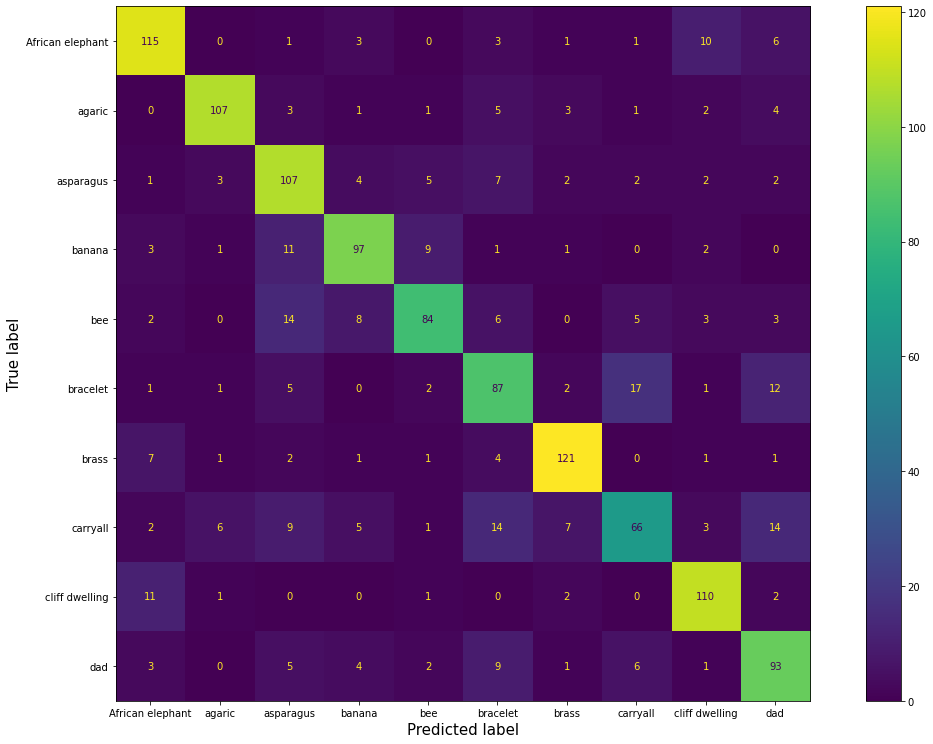

In [11]:
#Generate Confusion Matrix for Dual-stream model
cm = confusion_matrix(true_outputs,dual_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)

In [12]:
print(classification_report(true_outputs,single_pred_outputs))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       140
           1       0.92      0.77      0.84       127
           2       0.60      0.71      0.65       135
           3       0.72      0.70      0.71       125
           4       0.65      0.68      0.66       125
           5       0.56      0.69      0.62       128
           6       0.88      0.71      0.78       139
           7       0.66      0.51      0.58       127
           8       0.78      0.82      0.80       127
           9       0.60      0.65      0.62       124

    accuracy                           0.70      1297
   macro avg       0.71      0.70      0.70      1297
weighted avg       0.72      0.70      0.71      1297



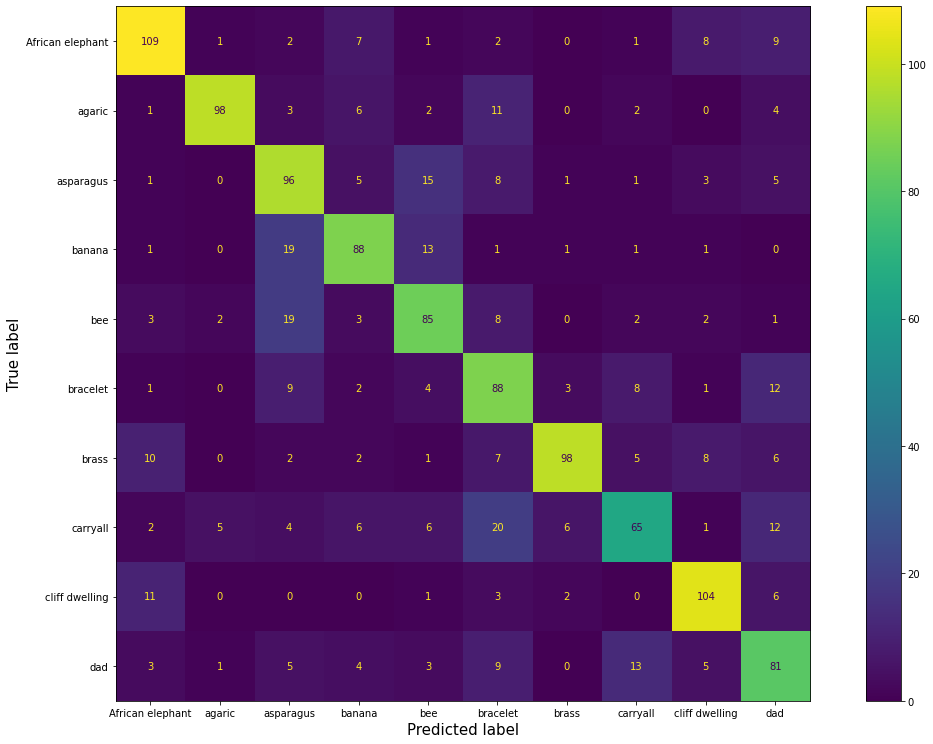

In [13]:
#Generate Confusion Matrix for Single-stream ResNet
cm = confusion_matrix(true_outputs,single_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)

### Testing the Blurred condition

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_blurred)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_blurred)

41/41 [==============================] - 9s 214ms/step - loss: 1.6913 - accuracy: 0.4857


In [14]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_blurred)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_blurred)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_blurred])
true_outputs = np.argmax(true_outputs,axis=1)

In [15]:
print(classification_report(true_outputs,dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.55      0.41      0.47       140
           1       0.95      0.16      0.27       127
           2       0.39      0.72      0.50       135
           3       0.70      0.38      0.49       125
           4       0.33      0.66      0.44       125
           5       0.27      0.74      0.40       128
           6       0.88      0.27      0.42       139
           7       0.45      0.39      0.42       127
           8       0.75      0.09      0.17       127
           9       0.42      0.31      0.36       124

    accuracy                           0.41      1297
   macro avg       0.57      0.41      0.39      1297
weighted avg       0.57      0.41      0.40      1297



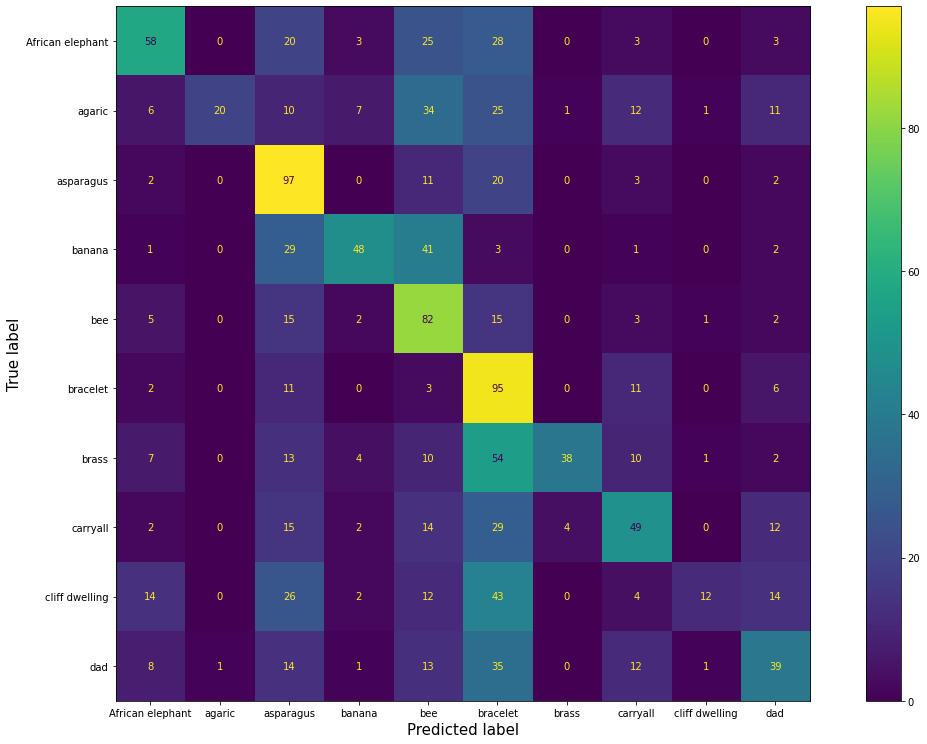

In [19]:
#Generate Confusion Matrix for Dual-stream model
cm = confusion_matrix(true_outputs,dual_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)

In [20]:
print(classification_report(true_outputs,single_pred_outputs))

              precision    recall  f1-score   support

           0       0.64      0.54      0.58       140
           1       0.89      0.26      0.40       127
           2       0.58      0.56      0.57       135
           3       0.68      0.48      0.56       125
           4       0.35      0.65      0.45       125
           5       0.31      0.60      0.41       128
           6       0.80      0.29      0.43       139
           7       0.49      0.39      0.43       127
           8       0.67      0.59      0.63       127
           9       0.35      0.51      0.42       124

    accuracy                           0.49      1297
   macro avg       0.58      0.49      0.49      1297
weighted avg       0.58      0.49      0.49      1297



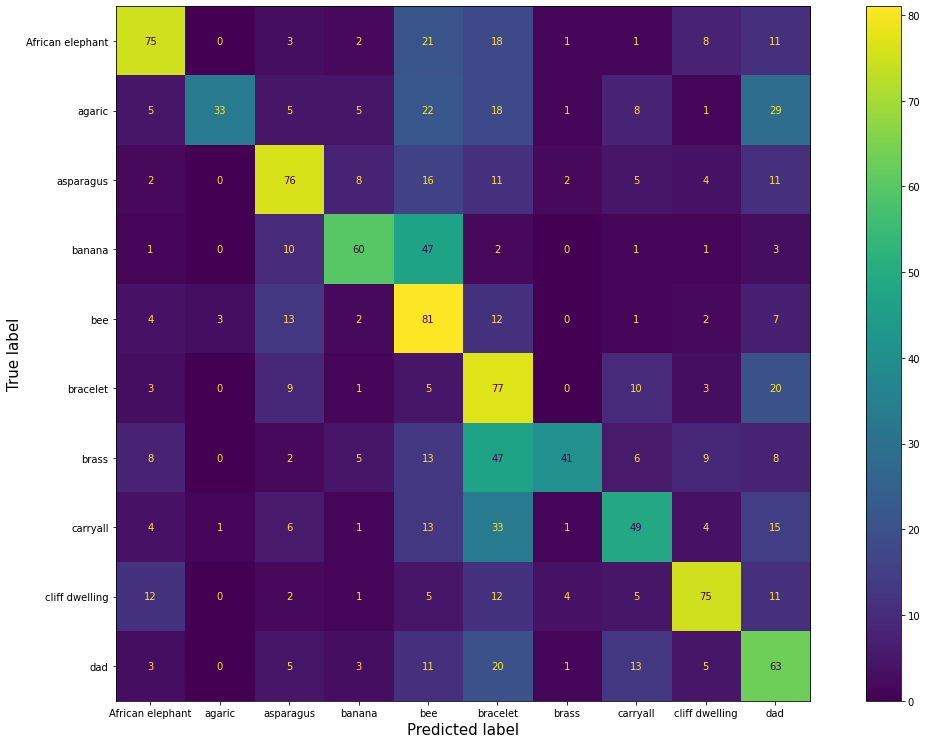

In [21]:
#Generate Confusion Matrix for Single-stream ResNet
cm = confusion_matrix(true_outputs,single_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)